Feasible solution found at z = 0
A coefficients: [9.93869816e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00]
B coefficients: [9.93869816e-07 0.00000000e+00 2.48467454e-05 0.00000000e+00]


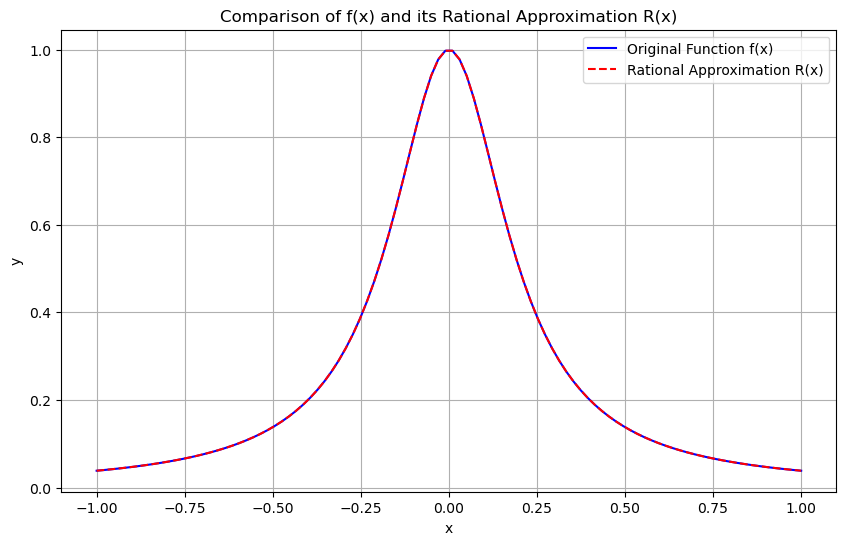

In [1]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# Defining the target function
def f(x):
    return 1 / (1 + 25 * x**2)
    #return x/(x+3)
    #return x**3

# Generating the Chebyshev nodes
def chebyshev_nodes(n):
    return np.cos((2 * np.arange(n) + 1) * np.pi / (2 * n))

# Check feasibility function
def check_feasibility(f, m, n, z, t, delta=1e-6):

    if not isinstance(delta, float) or delta <= 0:
        raise ValueError("Delta must be a positive float.")
    if not (isinstance(m, int) and isinstance(n, int)) or m <= 0 or n <= 0:
        raise ValueError("m and n must be positive integers.")

    A = []
    b = []

    # Equations 9 and 10
    for t_i in t:
        G = np.array([t_i**i for i in range(m)])
        #   print(f'G(x) = {G}')
        H = np.array([t_i**i for i in range(n)])
        #   print(f'H(x) = {H}')

        f_ti = f(t_i)
        A.append(np.concatenate(([-1], -G, (f_ti - z) * H)))
        b.append(0)
        A.append(np.concatenate(([-1], G, -(f_ti + z) * H)))
        b.append(0)

    # Equation 11
    for t_i in t:
        H = np.array([t_i**i for i in range(n)])
        A.append(np.concatenate(([0], np.zeros(m), -H)))
        b.append(-delta)

    # Objective function: Minimizing the theta
    c = np.concatenate(([1], np.zeros(m + n)))     # Minimizing only theta c = [1,0,0,0,0,0,0,0,0]

    # Linear programming problem
    lpp_result = linprog(c, A_ub=A, b_ub=b, bounds=None, method='highs')
    #print(f'lpp_result {lpp_result}')


     # Checking feasibility and extracting coefficients

    if lpp_result.success:
         # Extract coefficients for A and B
        coefficients = lpp_result.x[1:]      # Excluding 0th element, since it corresponds to theta
        A_coefficients = coefficients[:m]    # Coefficients of A (numerator)
        B_coefficients = coefficients[m:]    # Coefficients of B (denominator)
        return True, A_coefficients, B_coefficients
    else:
        return False, None, None


# Bisection algorithm
def bisection_algorithm(f, m, n, epsilon=1e-2, N=100):


    t = chebyshev_nodes(N)
    l = 0
   # u = 1
    u = 0.5 * np.max(np.abs(f(t))) - 0.5 * np.min(np.abs(f(t)))
    while u - l > epsilon:
        z = (u + l) / 2
        feasible, _, _ = check_feasibility(f, m, n, z, t)
        if feasible:
            u = z
        else:
            l = z

    final_feasible, A_coefficients, B_coefficients = check_feasibility(f, m, n, l, t)
    return final_feasible, l, A_coefficients, B_coefficients


# New function to plot the original function and its rational approximation
def plot_rational_approximation(f, A_coeffs, B_coeffs, N=100):
    x_values = np.linspace(-1, 1, N)
    f_values = f(x_values)

    A_values = np.polyval(A_coeffs[::-1], x_values)  # Reversing coefficients for np.polyval because np.polyval expects them in descending order of powers
    B_values = np.polyval(B_coeffs[::-1], x_values)
    R_values = A_values / B_values     # rational function r(x)

    plt.figure(figsize=(10, 6))
    plt.plot(x_values, f_values, label='Original Function f(x)', color='blue')
    plt.plot(x_values, R_values, label='Rational Approximation R(x)', color='red', linestyle='--')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Comparison of f(x) and its Rational Approximation R(x)')
    plt.legend()
    plt.grid(True)
    plt.show()

# execution
feasible, optimal_z, A_coeffs, B_coeffs = bisection_algorithm(f, 4, 4)
if feasible:
    print("Feasible solution found at z =", optimal_z)
    print("A coefficients:", A_coeffs)
    print("B coefficients:", B_coeffs)
    plot_rational_approximation(f, A_coeffs, B_coeffs)
else:
    print("No feasible solution found.")


